In [1]:
import pandas as pd
from lifelines import CoxPHFitter
import numpy as np
import copy
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from IPython.display import display
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
from statannot import add_stat_annotation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


In [2]:
def balance_dataset(diab_metadata, diab_data, ko_picrust_data):
    num_of_samples_per_pat = diab_metadata.groupby(by = ["Subject_ID"]).count()["SampleID"].max()

    for cur_pat in diab_metadata["Subject_ID"].unique():
        cur_pat_data = diab_metadata[diab_metadata["Subject_ID"] == cur_pat]
        for i in range(num_of_samples_per_pat - cur_pat_data.shape[0]):

            cur_added_row_metadata = cur_pat_data.sample(1)
            cur_sample_to_add = cur_added_row_metadata["SampleID"].iloc[0]
            cur_added_row_metadata["SampleID"] = cur_sample_to_add + "_" + str(i)
            diab_metadata = diab_metadata.append(cur_added_row_metadata)


            cur_added_row_data = diab_data.loc[[cur_sample_to_add]]
            cur_added_row_data.index = [cur_added_row_data.index[0] + "_" + str(i)]
            diab_data = diab_data.append(cur_added_row_data)


            cur_added_row_ko = ko_picrust_data.loc[[cur_sample_to_add]]
            cur_added_row_ko.index = [cur_added_row_ko.index[0] + "_" + str(i)]
            ko_picrust_data = ko_picrust_data.append(cur_added_row_ko)
    return diab_metadata, diab_data, ko_picrust_data

In [3]:
def train_model_with_mw_fs(data_to_test_mw, metadata_to_input, metadata, threshold = 0.05):
    metadata_to_input["is_sero"] = metadata["T1D_Status"] == "control"
    
    controls = list(metadata[metadata["T1D_Status"] == "control"].index)
    seroconverters = list(metadata[~(metadata["T1D_Status"] == "control")].index)

    data_controls = data_to_test_mw[data_to_test_mw.index.isin(controls)]
    data_seroconverters = data_to_test_mw[data_to_test_mw.index.isin(seroconverters)]
    
    data_to_test_filtered = data_to_test_mw
    if data_to_test_mw.shape[1] != 0:
        p_vals = pd.DataFrame({key: mannwhitneyu(data_controls[key], data_seroconverters[key]) for key in data_controls.columns}).T.sort_values(by = 1)
        data_to_test_filtered = data_to_test_mw.loc[:, p_vals[p_vals[1] <threshold].index]
    
    data_for_mod = pd.merge(data_to_test_filtered, metadata_to_input, left_index=True, right_index=True)
    
    cph = CoxPHFitter(penalizer=0.01)
    data_for_mod = data_for_mod.drop(["is_sero"], axis = 1)
#     data_for_mod = data_for_mod.drop(["post_sero"], axis = 1)
    cph.fit(df = data_for_mod, duration_col = "Age_at_Collection", event_col='post_sero')
    return cph, data_for_mod
    
def test_iteratively(data_to_test_mw, metadata_to_input, metadata, threshold = 0.05):
    partial_hazards = pd.DataFrame()
    all_sum = {}
    for patient in set(metadata["Subject_ID"]):
        print(patient)
        metadata_one_pat_out = metadata[metadata["Subject_ID"] != patient]
        data_one_pat_out = data_to_test_mw[data_to_test_mw.index.isin(metadata_one_pat_out.index)]
        metadata_to_input_one_pat_out = metadata_to_input[metadata_to_input.index.isin(metadata_one_pat_out.index)]
        cph, data_for_mod = train_model_with_mw_fs(data_one_pat_out, metadata_to_input_one_pat_out, metadata_one_pat_out, threshold)
        
        merged_data = metadata
        
        merged_data = pd.merge(data_to_test_mw, metadata, left_index = True, right_index = True)
        merged_data_one_pat = merged_data[merged_data["Subject_ID"] == patient]
        
        merged_data_one_pat.loc[:, data_for_mod.columns]
        
        cur_partial_haz = cph.predict_log_partial_hazard(merged_data_one_pat.drop(["Subject_ID"], axis = 1))
        cur_partial_haz = pd.DataFrame(cur_partial_haz, columns = ["risk score"])
        cur_partial_haz["patient"] = patient
        partial_hazards = partial_hazards.append(cur_partial_haz)
        all_sum[patient] = cph.summary
    return partial_hazards, all_sum


In [4]:
def test_iteratively_shuffle(data_to_test_mw, metadata_to_input, diab_metadata, con_ages, threshold = 0.05, window_size = 150):
    
    tmp_con_ages = copy.deepcopy(con_ages)
    
    metadata_with_post_sero_shuff = pd.DataFrame()

    shuff_pat_list = list(set(diab_metadata["Subject_ID"]))
    np.random.shuffle(shuff_pat_list)
    shuff_pat_list[:11]

    con_ages = {}
    for patient in shuff_pat_list[:11]:
        cur_pat_metadata = diab_metadata[diab_metadata["Subject_ID"] == patient]

        cur_pat_metadata= cur_pat_metadata[cur_pat_metadata["Age_at_Collection"] > 150]
        cur_pat_metadata["post_sero"] = True
        con_ages[patient] = np.random.randint(np.min(cur_pat_metadata["Age_at_Collection"] + 1), 
                                    np.max(cur_pat_metadata["Age_at_Collection"] + 1))

    

    for patient in set(diab_metadata["Subject_ID"]):
        cur_pat_metadata = diab_metadata[diab_metadata["Subject_ID"] == patient]

        cur_pat_metadata= cur_pat_metadata[cur_pat_metadata["Age_at_Collection"] > 150]
        cur_pat_metadata["post_sero"] = True

        if patient in con_ages:
            cur_pat_metadata["post_sero"] = cur_pat_metadata["Age_at_Collection"] < con_ages[patient]
            metadata_with_post_sero_shuff = metadata_with_post_sero_shuff.append(cur_pat_metadata)
            cur_pat_metadata = cur_pat_metadata.iloc[: np.sum(cur_pat_metadata["post_sero"]) + 1]
        else:
            metadata_with_post_sero_shuff = metadata_with_post_sero_shuff.append(cur_pat_metadata)

    metadata_with_post_sero_shuff["post_sero"] = ~metadata_with_post_sero_shuff["post_sero"]
    metadata_with_post_sero_shuff.index = metadata_with_post_sero_shuff["SampleID"]
    metadata_with_post_sero_shuff = metadata_with_post_sero_shuff.drop(["SampleID"], axis = 1)
    

    

    
    partial_hazards = pd.DataFrame()
    all_sum = {}
    for patient in set(metadata_with_post_sero_shuff["Subject_ID"]):
        
        metadata_one_pat_out = metadata_with_post_sero_shuff[metadata_with_post_sero_shuff["Subject_ID"] != patient]
        data_one_pat_out = data_to_test_mw[data_to_test_mw.index.isin(metadata_one_pat_out.index)]
        metadata_to_input_one_pat_out = metadata_to_input[metadata_to_input.index.isin(metadata_one_pat_out.index)]
        cph, data_for_mod = train_model_with_mw_fs(data_one_pat_out, metadata_to_input_one_pat_out, metadata_one_pat_out, threshold)
        
        merged_data = metadata_with_post_sero_shuff
        
        merged_data = pd.merge(data_to_test_mw, metadata_with_post_sero_shuff, left_index = True, right_index = True)
        merged_data_one_pat = merged_data[merged_data["Subject_ID"] == patient]
        
        merged_data_one_pat.loc[:, data_for_mod.columns]
        
        cur_partial_haz = cph.predict_log_partial_hazard(merged_data_one_pat.drop(["Subject_ID"], axis = 1))
        cur_partial_haz = pd.DataFrame(cur_partial_haz, columns = ["risk score"])
        cur_partial_haz["patient"] = patient
        partial_hazards = partial_hazards.append(cur_partial_haz)
        all_sum[patient] = cph.summary
    
    res_shuff = calc_results_from_hazard(partial_hazards, metadata_with_post_sero_shuff)
    auc, aupr = calc_AUC_AUPR(res_shuff, window_size)
    con_ages = tmp_con_ages
    return auc, aupr


In [5]:
colors = {"control": "#B0E0E6", "seroconverted": "#FF7F50", "T1D": "#8B0000"}

def calc_results_from_hazard(partial_hazards, metadata):
    res = pd.merge(partial_hazards, metadata[["post_sero", "Age_at_Collection", "T1D_Status"]], 
         left_index = True, right_index = True)
    max_values = res.groupby('patient')['post_sero'].max()
    res = res.merge(max_values, left_on='patient', right_index=True, suffixes=('', '_max'))
    return res

def boxplot(res, min_age = 0, max_age = 5000, pre_sero = False):
    res = res[(res["Age_at_Collection"] > min_age) & (res["Age_at_Collection"]  <= max_age)]
    if pre_sero:
        res = res[(res["post_sero"]  == False)]
        
    ax = sns.boxplot(data = res, y = "risk score", x = "T1D_Status",
               order = ["control", "seroconverted", "T1D"], palette = colors)

    test_results = add_stat_annotation(ax, data = res, y = "risk score", x = "T1D_Status",
                                       order = ["control", "seroconverted", "T1D"],
                                       box_pairs=[("control", "seroconverted"), ("control", "T1D"), ("seroconverted", "T1D")],
                                       test='Mann-Whitney', text_format='star',
                                       loc='outside', verbose=2)
    plt.show()
    
def calc_AUC_AUPR(res, low_window = 150, up_window = 0):
#     np.random.seed(0)
    cur_window_res = pd.DataFrame()
    for patient in res["patient"].unique():
        cur_pat_data = res[res["patient"] == patient]
        if patient in con_ages:
            cur_con_age = con_ages[patient]
        else:
            cur_con_age = int(cur_pat_data.sample(n =1)["Age_at_Collection"])
            
        cur_timepoint_to_test = cur_pat_data[(cur_pat_data["Age_at_Collection"] >= (cur_con_age - low_window)) & (cur_pat_data["Age_at_Collection"] <= (cur_con_age + up_window))]

        cur_window_res = cur_window_res.append(cur_timepoint_to_test)

    tmp_ind = []
    for cur_ind in cur_window_res.index:
        if "_" in cur_ind:
            tmp_ind.append(cur_ind[:cur_ind.find("_")])
        else:
            tmp_ind.append(cur_ind)
    cur_window_res.index = tmp_ind
    cur_window_res = cur_window_res.drop_duplicates()

    auc = roc_auc_score(cur_window_res[~cur_window_res["post_sero"]]["post_sero_max"], cur_window_res[~cur_window_res["post_sero"]]["risk score"])
    aupr = average_precision_score(cur_window_res[~cur_window_res["post_sero"]]["post_sero_max"], cur_window_res[~cur_window_res["post_sero"]]["risk score"])
#     print("auc is %f, aupr is %f" % (auc, aupr))
    return auc, aupr


def fs_summary(all_summary):
    all_variables = {}
    for cur_pat in all_summary.keys():
        for variable in all_summary[cur_pat].index:
            if variable not in all_variables:
                all_variables[variable] = []

            all_variables[variable].append(all_summary_microbiome[cur_pat].loc[variable, "p"])
    all_variables_summary = pd.DataFrame(columns = ["variable", "count", "mean", "min", "max", "<0.05"])
    for variable in all_variables:
        tmp_dict = {"variable": variable}
        tmp_dict["count"] = len(all_variables[variable])
        tmp_dict["mean"] = np.mean(all_variables[variable])
        tmp_dict["min"] = np.min(all_variables[variable])
        tmp_dict["max"] = np.max(all_variables[variable])
        tmp_dict["<0.05"] = np.sum(np.array(all_variables[variable]) < 0.05)
        all_variables_summary = all_variables_summary.append(tmp_dict, ignore_index=True)
    return all_variables_summary        


In [29]:
def create_timeline(res):
    patients_controls = res[res["T1D_Status"] == "control"]['patient'].unique()

    patients_sero = res[res["T1D_Status"] == "seroconverted"]['patient'].unique()

    patients_diab = res[res["T1D_Status"] == "T1D"]['patient'].unique()


    # Create a new figure
    plt.figure(figsize=(30, 12))

    # Iterate through patients and plot their scores
    for i, patient in enumerate(patients_controls):
        patient_data = res[res['patient'] == patient]
        plt.scatter(patient_data['Age_at_Collection'], [i] * len(patient_data), 
                    s = (patient_data['risk score'] + 10) ** 2.5, c=colors["control"], label=patient, cmap='viridis')

    for i, patient in enumerate(patients_sero):
        patient_data = res[res['patient'] == patient]
        plt.scatter(patient_data['Age_at_Collection'], [i + len(patients_controls)] * len(patient_data), 
                    s = (patient_data['risk score'] + 10) ** 2.5, c=colors["seroconverted"], label=patient, cmap='viridis')
        plt.vlines(x = con_ages[patient], ymin = i  + len(patients_controls) - 0.5, 
                    ymax = i + len(patients_controls) + 0.5, linewidth=5, color = "black")


    for i, patient in enumerate(patients_diab):
        patient_data = res[res['patient'] == patient]
        plt.scatter(patient_data['Age_at_Collection'] , [i + len(patients_controls) + len(patients_sero)] * len(patient_data), 
                    s = (patient_data['risk score'] + 10) ** 2.5, c=colors["T1D"], label=patient, cmap='viridis')
        plt.vlines(x = con_ages[patient], ymin = i  + len(patients_controls) + len(patients_sero) - 0.5, 
                    ymax = i + len(patients_controls) + len(patients_sero) + 0.5, linewidth=5, color = "black")
        plt.vlines(x = diab_ages[patient], ymin = i  + len(patients_controls) + len(patients_sero) - 0.5, 
                    ymax = i + len(patients_controls) + len(patients_sero) + 0.5, linewidth=5, color = "black")


    # Set labels and legend
    plt.xlabel('Age')

    patients = list(patients_controls)
    [patients.append(cur_pat) for cur_pat in patients_sero]
    [patients.append(cur_pat) for cur_pat in patients_diab]

    plt.yticks(range(len(patients)), patients)
    plt.title('Patient Scores Over Time')
    legend = plt.legend(handles=[
    plt.Line2D([0], [0], color="#B0E0E6", lw=2, label="control"),
    plt.Line2D([0], [0], color="#FF7F50", lw=2, label="seroconverted"),
    plt.Line2D([0], [0], color="#8B0000", lw=2, label="T1D")], fontsize=30, loc='lower right')
    
    # Show the plot
    plt.grid(True)
    plt.show()


In [7]:
con_ages = {"T013815": 350, "E026079": 580, "E022137": 562, "E018113": 587, "E017751": 175,
"E010629": 945, "E003989": 346, "T025418": 540, "E010937": 905, "E006574": 532, "E003251":357}

diab_ages = {"T025418": 880, "E010937": 960, "E006574": 1340, "E003251": 1168}

diab_data = pd.read_csv("feature-table_genus.tsv", sep = "\t", index_col=0)
diab_data.replace(0, 0.5, inplace=True) 
diab_data = diab_data.div(diab_data.sum())
diab_data = diab_data.T


shannon_diversity = pd.read_csv("alpha-diversity.tsv", sep = "\t", index_col=0)

ko_picrust_data = pd.read_csv("D:pred_metagenome_unstrat.tsv", sep = "\t", index_col=0)
ko_picrust_data.replace(0, 0.5, inplace=True)
ko_picrust_data = ko_picrust_data.div(ko_picrust_data.sum())
ko_picrust_data = ko_picrust_data.T

diab_metadata = pd.read_csv("metadata_qiime.tsv", sep = "\t")
diab_metadata = diab_metadata.sort_values(by = "Age_at_Collection")
diab_metadata["Gender_male"] =  diab_metadata["Gender"] == "male"
diab_metadata["delivery_vaginal"] =  diab_metadata["Delivery_Route"] == "vaginal"
diab_metadata["country_finland"] =  diab_metadata["Country"] == "Finland"
diab_metadata["bf_true"] =  diab_metadata["BF"] == True
diab_metadata["exclusive_bf_true"] =  diab_metadata["Exclusive_BF"] == True
diab_metadata = pd.merge(diab_metadata, shannon_diversity, left_on = "SampleID", right_index = True)

AbxAtCollection_list = {"Amoxicillin": [], "clavulanic acid": [], "Cefalexin": [], "Trimetoprime": [], 
                        "sulfadiazine": [], "Amoxicillin": [], "Azithromycin": [], "Cefaclor": []}
for i in range(diab_metadata.shape[0]):
    for antibiotic in AbxAtCollection_list.keys():
        if antibiotic in diab_metadata.iloc[i]["AbxAtCollection"]:
            AbxAtCollection_list[antibiotic].append(True)
        else:
            AbxAtCollection_list[antibiotic].append(False)
for antibiotic in AbxAtCollection_list.keys():
    diab_metadata[antibiotic] = AbxAtCollection_list[antibiotic]



diab_metadata, diab_data, ko_picrust_data = balance_dataset(diab_metadata, diab_data, ko_picrust_data)



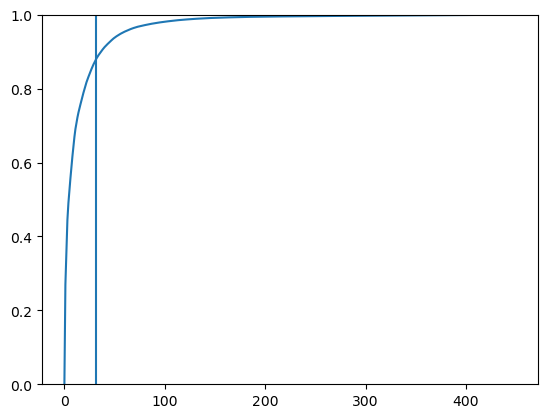

In [8]:
sns.lineplot([i for i in range(diab_data.shape[1]) ],
             [diab_data.sum().sort_values(ascending=False).iloc[:i].sum() / diab_data.sum().sum() for i in range(diab_data.shape[1])]            )
plt.ylim(0, 1)
plt.axvline(31)
plt.show()

diab_data = diab_data.loc[:, diab_data.columns.isin(diab_data.sum().sort_values(ascending=False).iloc[:31].index)]

In [9]:
# sns.lineplot([i for i in range(ko_picrust_data.shape[1]) ],
#              [ko_picrust_data.sum().sort_values(ascending=False).iloc[:i].sum() / ko_picrust_data.sum().sum() for i in range(ko_picrust_data.shape[1])]            )
ko_picrust_data = ko_picrust_data.loc[:, ko_picrust_data.columns.isin(ko_picrust_data.sum().sort_values(ascending=False).iloc[:792].index)]

In [10]:
log_odds = lambda x: np.log(x / (1 - x))
diab_data_log_odds = diab_data.applymap(log_odds)


ko_picrust_data_log_odds = ko_picrust_data.applymap(log_odds)

In [11]:
metadata_one_point_after_sero = pd.DataFrame()
metadata_with_post_sero = pd.DataFrame()
for patient in set(diab_metadata["Subject_ID"]):
    cur_pat_metadata = diab_metadata[diab_metadata["Subject_ID"] == patient]
    #only above 1 year
    cur_pat_metadata= cur_pat_metadata[cur_pat_metadata["Age_at_Collection"] > 150]
    cur_pat_metadata["post_sero"] = True
    
    if patient in con_ages:
        cur_pat_metadata["post_sero"] = cur_pat_metadata["Age_at_Collection"] < con_ages[patient]
        metadata_with_post_sero = metadata_with_post_sero.append(cur_pat_metadata)
        cur_pat_metadata = cur_pat_metadata.iloc[: np.sum(cur_pat_metadata["post_sero"]) + 1]
    else:
        metadata_with_post_sero = metadata_with_post_sero.append(cur_pat_metadata)
    cur_pat_metadata["post_sero"] = ~cur_pat_metadata["post_sero"]
    metadata_one_point_after_sero = metadata_one_point_after_sero.append(cur_pat_metadata)

metadata_one_point_after_sero.index = metadata_one_point_after_sero["SampleID"]
metadata_one_point_after_sero = metadata_one_point_after_sero.drop(["SampleID"], axis = 1)

metadata_with_post_sero["post_sero"] = ~metadata_with_post_sero["post_sero"]
metadata_with_post_sero.index = metadata_with_post_sero["SampleID"]
metadata_with_post_sero = metadata_with_post_sero.drop(["SampleID"], axis = 1)
metadata_with_post_sero

,Subject_ID,Case_Control,Gender,Delivery_Route,T1D_Diagnosed,Post_T1D_Diag,HLA_Risk_Class,AAB_positive,AAB_Post_LastNeg,AAB_Post_FistPos,...,exclusive_bf_true,shannon,Amoxicillin,clavulanic acid,Cefalexin,Trimetoprime,sulfadiazine,Azithromycin,Cefaclor,post_sero
SampleID,,,,,,,,,,,,,,,,,,,,,
G35417,E017824,control,female,cesarian,False,False,3,False,False,False,...,False,2.674443,False,False,False,False,False,False,False,False
G35445,E017824,control,female,cesarian,False,False,3,False,False,False,...,False,3.079532,False,False,False,False,False,False,False,False
G37005,E017824,control,female,cesarian,False,False,3,False,False,False,...,False,2.956429,False,False,False,False,False,False,False,False
G35448,E017824,control,female,cesarian,False,False,3,False,False,False,...,False,3.847568,False,False,False,False,False,False,False,False
G36824,E017824,control,female,cesarian,False,False,3,False,False,False,...,False,3.648194,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G36902_7,E026325,control,male,vaginal,False,False,3,False,False,False,...,False,5.104177,False,False,False,False,False,False,False,False
G37052_8,E026325,control,male,vaginal,False,False,3,False,False,False,...,False,5.079715,False,False,False,False,False,False,False,False
G37040_9,E026325,control,male,vaginal,False,False,3,False,False,False,...,False,4.777654,False,False,False,False,False,False,False,False


In [12]:

metadata_known_confounder = metadata_with_post_sero[["post_sero", "Age_at_Collection", "shannon", "Total_Reads",
                                                                    "Gender_male", "delivery_vaginal",
                                                                   "country_finland", "BF", "Eggs", "Fish", "Solid_Food",
                                                                    "Soy_Prod", "Rye", "Barley", "Buckwheat_Millet",
                                                                    'Amoxicillin', "Trimetoprime"
                                                                     ]]

partial_hazards_microbiome, all_summary_microbiome = test_iteratively(diab_data_log_odds, metadata_known_confounder, metadata_with_post_sero, threshold = 0.05)
partial_hazards_metadata, all_summary_metadata = test_iteratively(diab_data_log_odds[[]], metadata_known_confounder, metadata_with_post_sero, threshold = 0.05)


partial_hazards_kegg, all_summary_kegg = test_iteratively(ko_picrust_data_log_odds, metadata_known_confounder, metadata_with_post_sero, threshold = 0.0001)



E017824
T025411
E017751
E003251
T014292
E029817
T012808
E001463
E018113
E010629
E010590
T013815
E011279
E016924
T025418
E022137
E003989
E003872
E026079
E006673
E013487
E018268
E010937
E021406
E017833
T026177
E022852
E003061
E004016
E006646
E006547
E006574
E026325
E017824
T025411
E017751
E003251
T014292
E029817
T012808
E001463
E018113
E010629
E010590
T013815
E011279
E016924
T025418
E022137
E003989
E003872
E026079
E006673
E013487
E018268
E010937
E021406
E017833
T026177
E022852
E003061
E004016
E006646
E006547
E006574
E026325
E017824
T025411
E017751
E003251
T014292
E029817
T012808
E001463
E018113
E010629
E010590
T013815
E011279
E016924
T025418
E022137
E003989
E003872
E026079
E006673
E013487
E018268
E010937
E021406
E017833
T026177
E022852
E003061
E004016
E006646
E006547
E006574
E026325


In [13]:
res_microbiome = calc_results_from_hazard(partial_hazards_microbiome, metadata_with_post_sero)
res_metadata = calc_results_from_hazard(partial_hazards_metadata, metadata_with_post_sero)
res_kegg = calc_results_from_hazard(partial_hazards_kegg, metadata_with_post_sero)
res_microbiome

,risk score,patient,post_sero,Age_at_Collection,T1D_Status,post_sero_max
G35417,1.302193,E017824,False,177,control,False
G35445,1.997038,E017824,False,214,control,False
G35447,0.640130,E017824,False,321,control,False
G35448,2.702727,E017824,False,265,control,False
G35876,1.009113,E017824,False,354,control,False
...,...,...,...,...,...,...
G36902_7,0.088145,E026325,False,477,control,False
G37052_8,-0.413215,E026325,False,832,control,False
G37040_9,0.856643,E026325,False,738,control,False
G37048_10,-0.781205,E026325,False,800,control,False


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control v.s. seroconverted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.545e-01 U_stat=2.763e+04
seroconverted v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.783e-01 U_stat=4.026e+03
control v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.295e-03 U_stat=1.134e+04


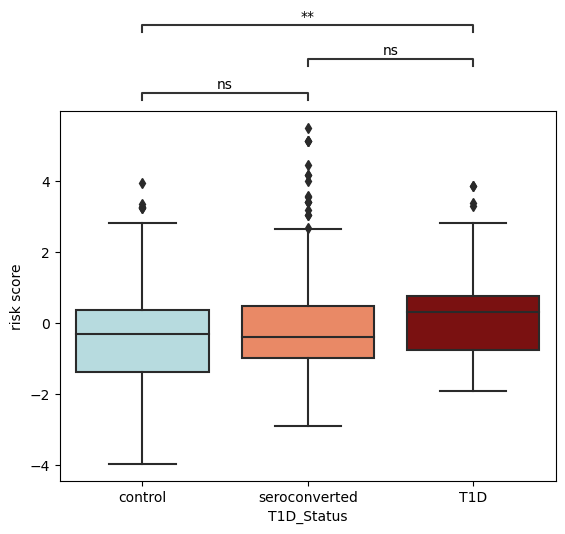

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control v.s. seroconverted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.224e+04
seroconverted v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.627e-07 U_stat=1.087e+03
control v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.558e-11 U_stat=4.134e+03


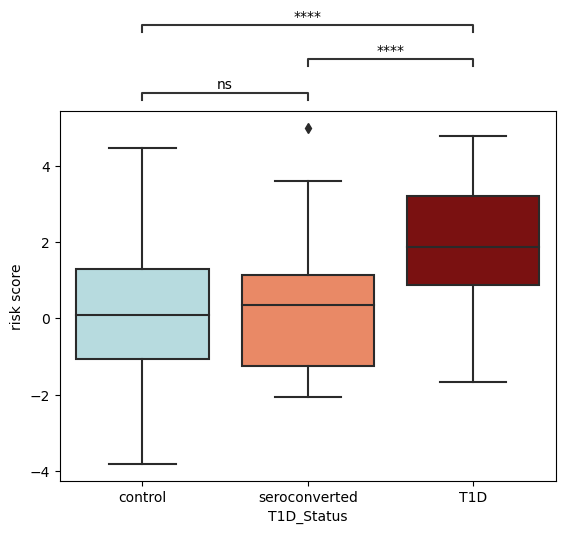

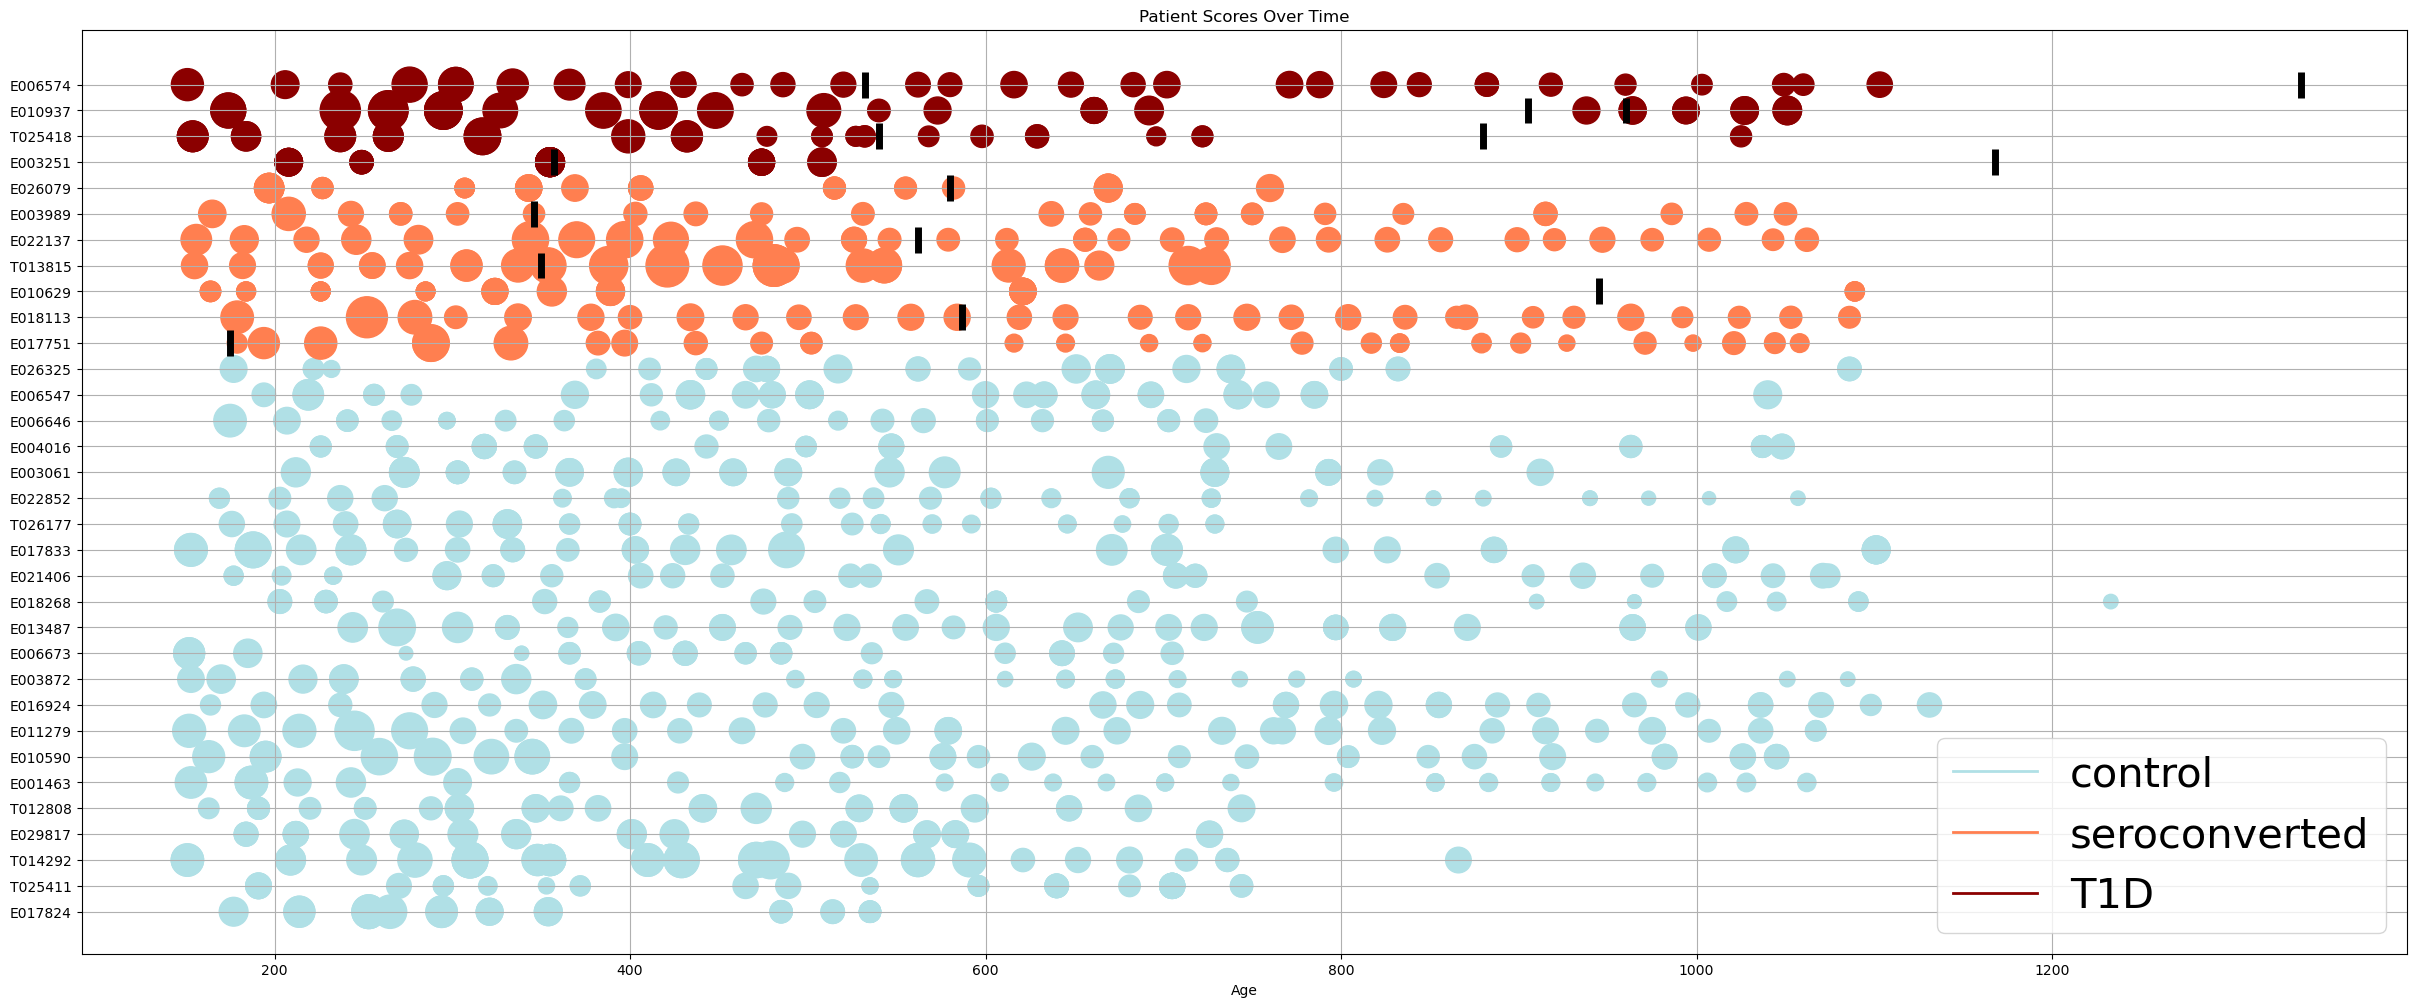

,variable,count,mean,min,max,<0.05
0,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,33,0.002367,1.152354e-09,0.065064,32
1,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,33,0.162286,2.275703e-02,0.628948,3
2,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,23,0.032422,4.868143e-04,0.311069,21
3,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,33,0.109046,7.406927e-03,0.743712,12
4,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,32,0.003167,9.879326e-06,0.017743,32
5,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,33,0.008398,2.095147e-04,0.057209,32
6,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,29,0.013652,1.694966e-04,0.201810,27
7,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,22,0.795011,4.228928e-01,0.995774,0
8,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,28,0.334255,1.329359e-01,0.566924,0
9,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,27,0.822332,3.484893e-01,0.996886,0


In [30]:
calc_AUC_AUPR(res_microbiome, 150)
boxplot(res_microbiome, min_age = 365)
boxplot(res_microbiome, min_age = 0, max_age= 500, pre_sero = True)
create_timeline(res_microbiome)

fs_summary(all_summary_microbiome)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control v.s. seroconverted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.195e-01 U_stat=3.181e+04
seroconverted v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.842e-02 U_stat=3.842e+03
control v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.902e-01 U_stat=1.324e+04


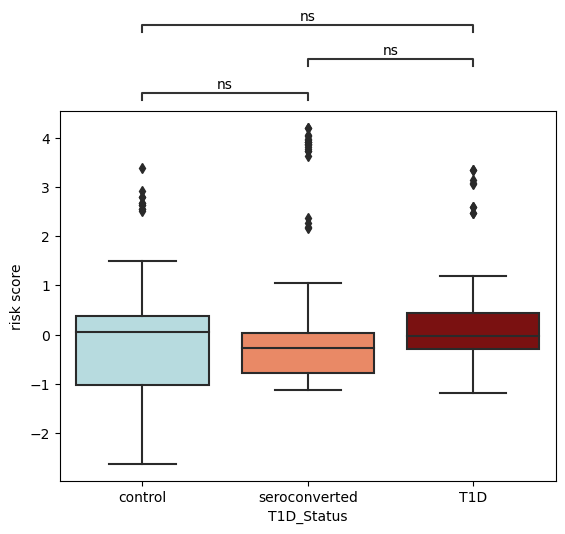

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control v.s. seroconverted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.216e+04
seroconverted v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.953e-08 U_stat=1.026e+03
control v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.145e-10 U_stat=4.180e+03


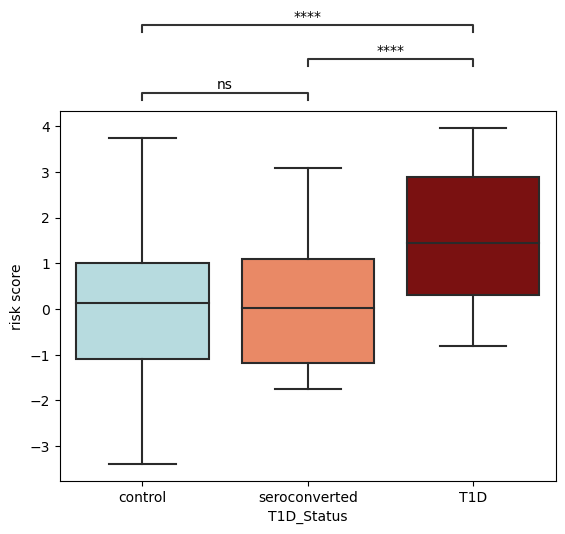

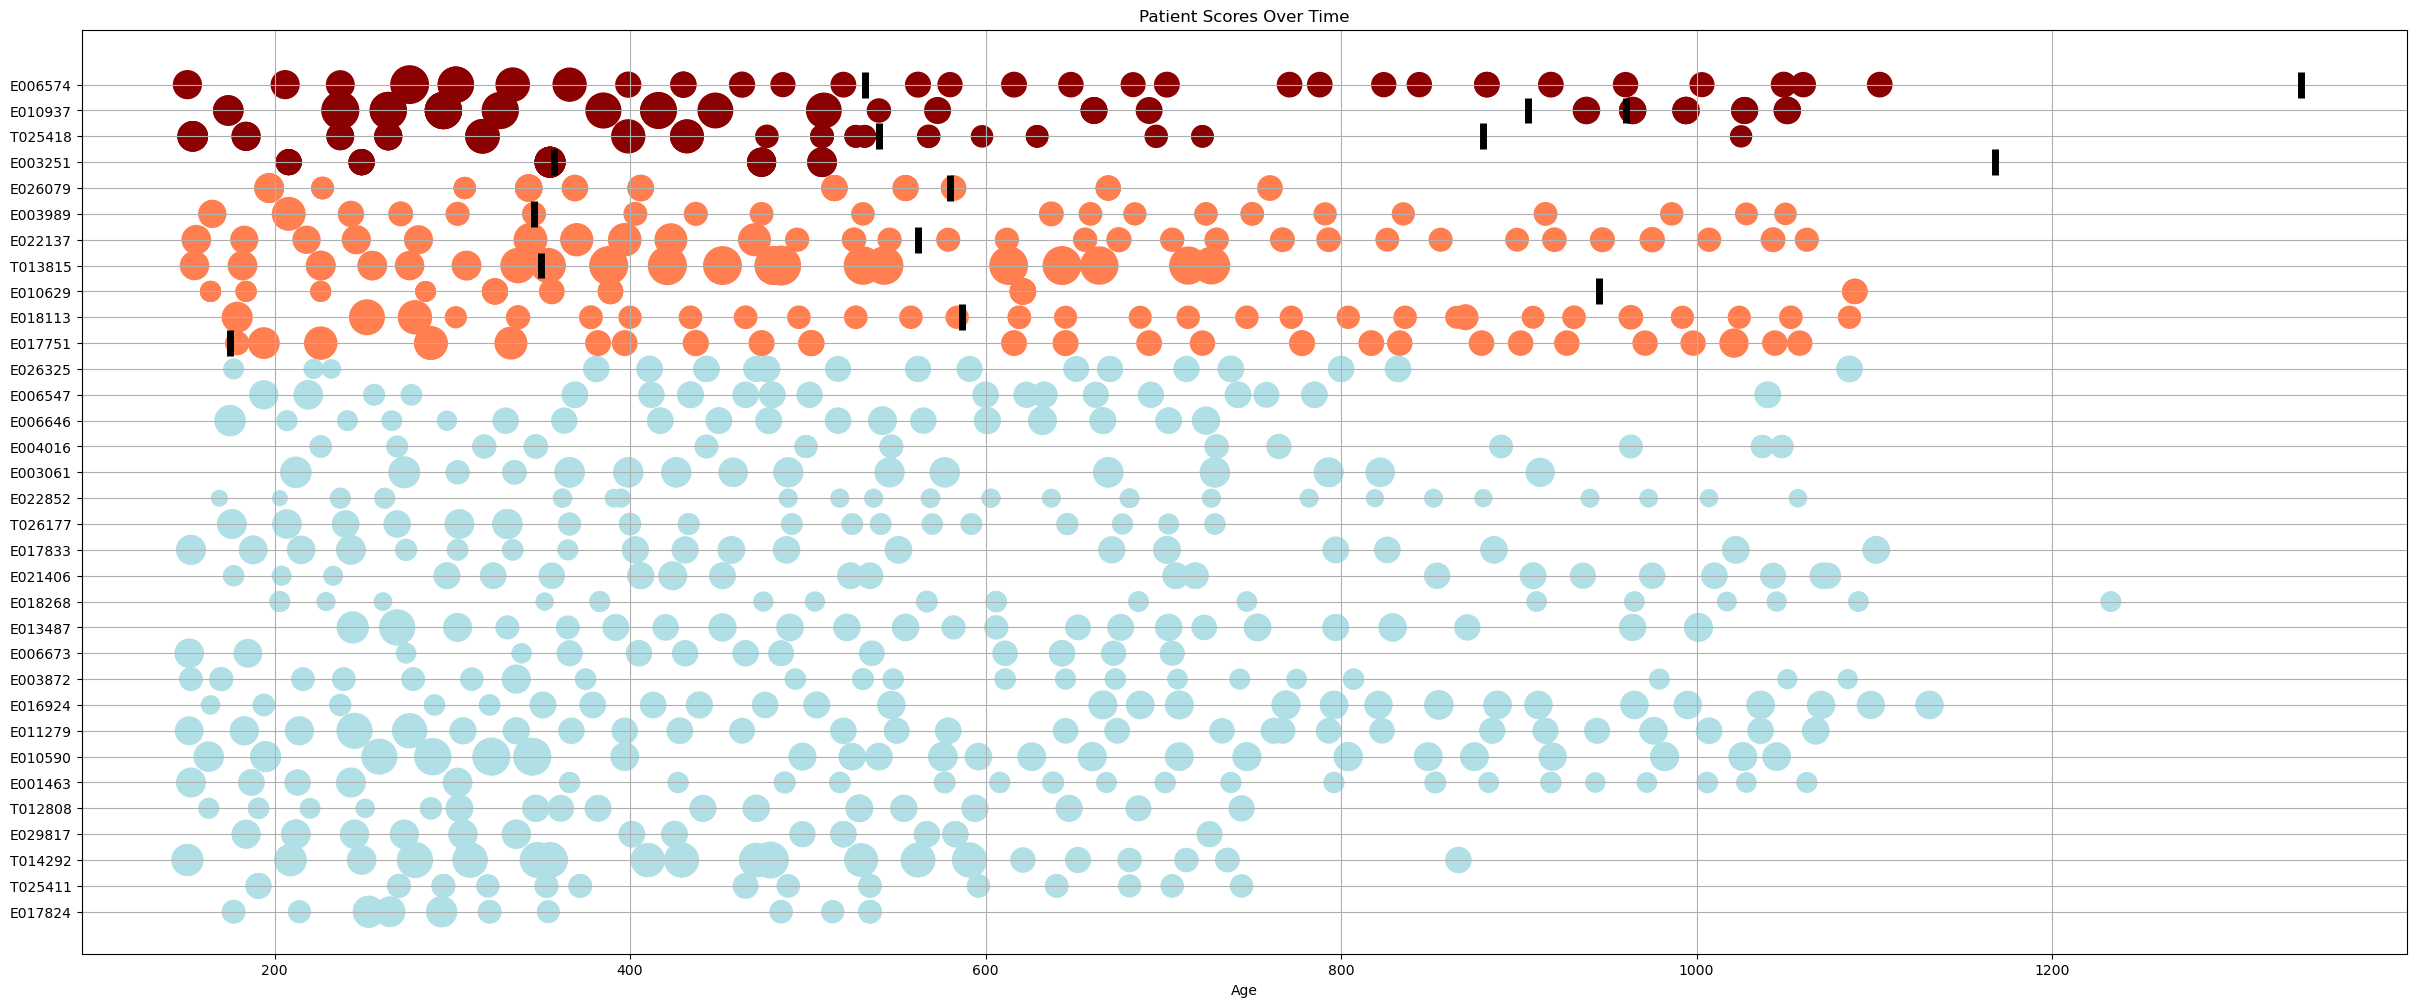

,variable,count,mean,min,max,<0.05
0,shannon,33,0.515019,4.054911e-02,0.999131,1
1,Total_Reads,33,0.566591,1.057270e-01,0.895827,0
2,Gender_male,33,0.114291,2.339547e-03,0.631815,13
3,delivery_vaginal,33,0.103238,3.694410e-02,0.283565,3
4,country_finland,33,0.151373,4.317027e-04,0.934482,8
5,BF,33,0.000002,2.690538e-15,0.000061,33
6,Eggs,33,0.000020,3.322171e-08,0.000497,33
7,Fish,33,0.724338,5.652634e-01,0.877687,0
8,Solid_Food,33,1.000000,1.000000e+00,1.000000,0
9,Soy_Prod,33,0.519535,1.782848e-03,0.981606,1


In [15]:
calc_AUC_AUPR(res_metadata, 150)

boxplot(res_metadata, min_age = 365)
boxplot(res_metadata, min_age = 0, max_age= 500, pre_sero = True)
create_timeline(res_metadata)
fs_summary(all_summary_metadata)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control v.s. seroconverted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.763e-01 U_stat=3.329e+04
seroconverted v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.372e-04 U_stat=3.246e+03
control v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.721e-03 U_stat=1.143e+04


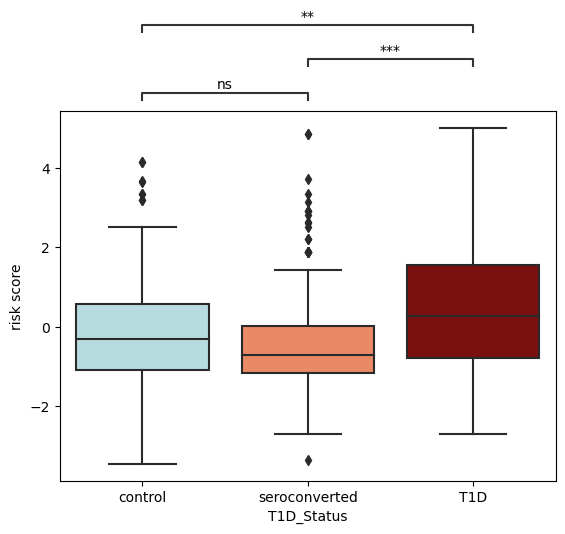

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

control v.s. seroconverted: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.736e-02 U_stat=1.448e+04
seroconverted v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.870e-08 U_stat=9.970e+02
control v.s. T1D: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.765e-08 U_stat=4.925e+03


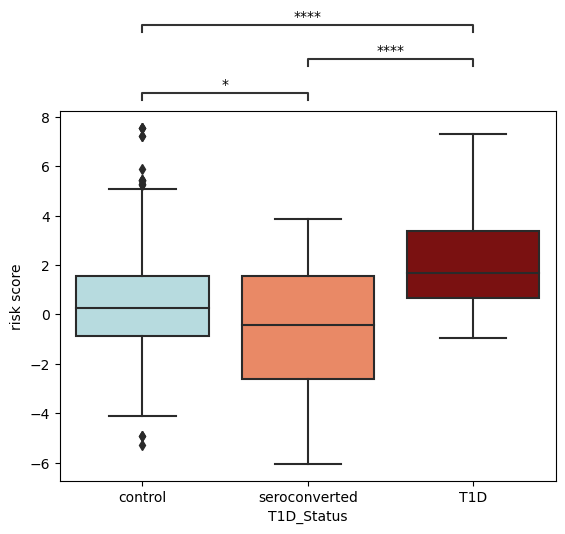

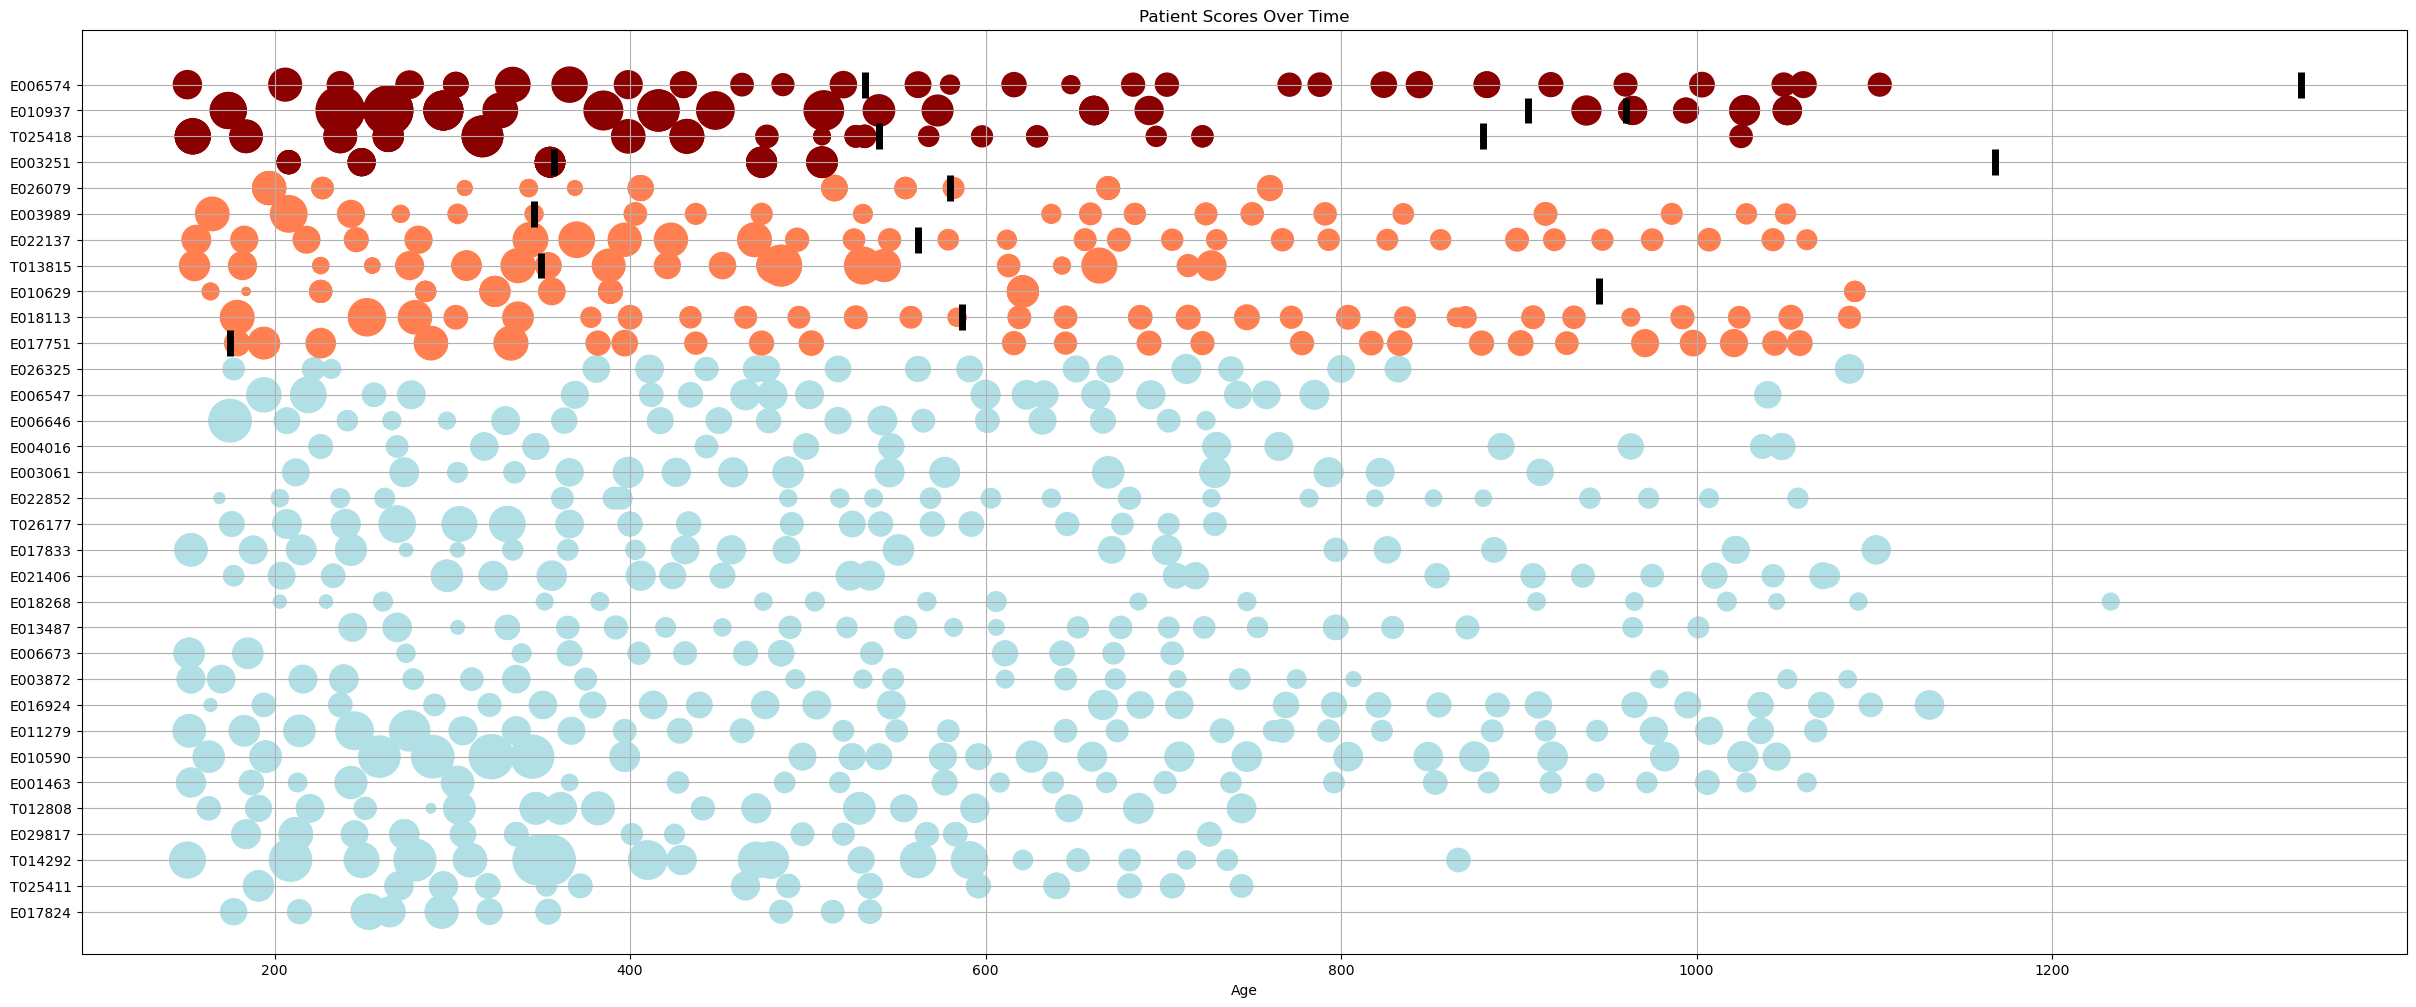

In [16]:
calc_AUC_AUPR(res_kegg, 150)
boxplot(res_kegg, min_age = 365)
boxplot(res_kegg, min_age = 0, max_age= 500, pre_sero = True)
create_timeline(res_kegg)

# fs_summary(all_summary_kegg)

In [44]:
all_shuf_auc_aupr = [test_iteratively_shuffle(diab_data_log_odds, metadata_known_confounder, diab_metadata, con_ages, threshold = 0.05, window_size = 250) for i in range(100)]
all_shuffled_auc = [cur_shuf_auc_aupr[0] for cur_shuf_auc_aupr in all_shuf_auc_aupr]
all_shuffled_aupr = [cur_shuf_auc_aupr[1] for cur_shuf_auc_aupr in all_shuf_auc_aupr]

100
150
250
365
500
750


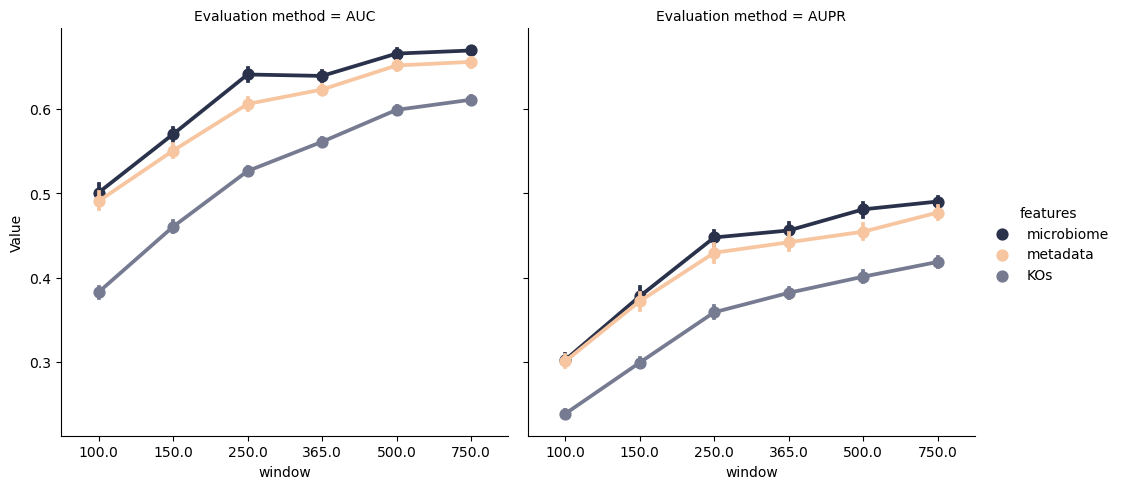

In [18]:
all_auprs_agg = pd.DataFrame(columns = ["Value", "Evaluation method", "Features", "Window"])

window_size = 150
for window_size in [100, 150, 250, 365, 500, 750]:
    print(window_size)
    for i in range(100):
        tmp_auc_aupr = calc_AUC_AUPR(res_microbiome, window_size)
        all_auprs_agg = all_auprs_agg.append({"Value": tmp_auc_aupr[0], "Evaluation method": "AUC", 
                                              "features": "microbiome", "window": window_size},
                                            ignore_index=True)
        
        all_auprs_agg = all_auprs_agg.append({"Value": tmp_auc_aupr[1], "Evaluation method": "AUPR", 
                                              "features": "microbiome", "window": window_size},
                                            ignore_index=True)
        
        tmp_auc_aupr = calc_AUC_AUPR(res_metadata, window_size)
        all_auprs_agg = all_auprs_agg.append({"Value": tmp_auc_aupr[0], "Evaluation method": "AUC", 
                                              "features": "metadata", "window": window_size},
                                            ignore_index=True)
        
        all_auprs_agg = all_auprs_agg.append({"Value": tmp_auc_aupr[1], "Evaluation method": "AUPR", 
                                              "features": "metadata", "window": window_size},
                                            ignore_index=True)
        
        tmp_auc_aupr = calc_AUC_AUPR(res_kegg, window_size)
        all_auprs_agg = all_auprs_agg.append({"Value": tmp_auc_aupr[0], "Evaluation method": "AUC", 
                                              "features": "KOs", "window": window_size},
                                            ignore_index=True)
        
        all_auprs_agg = all_auprs_agg.append({"Value": tmp_auc_aupr[1], "Evaluation method": "AUPR", 
                                              "features": "KOs", "window": window_size},
                                            ignore_index=True)

features_colors = {"metadata": "#F7C59F", "microbiome": "#2A324B", "KOs": "#767B91"}

sns.catplot(data = all_auprs_agg, x = "window", y = "Value", hue = "features", col = "Evaluation method",
           kind = "point", errorbar="se", palette = features_colors)

In [45]:
all_auprs_agg.groupby(by = ["Evaluation method", "features", "window"]).mean()

Value
Evaluation method features   window          
AUC               KOs        100.0   0.382731
                             150.0   0.460262
                             250.0   0.526203
                             365.0   0.560872
                             500.0   0.598696
                             750.0   0.610685
                  metadata   100.0   0.490529
                             150.0   0.550402
                             250.0   0.605656
                             365.0   0.622796
                             500.0   0.651285
                             750.0   0.655576
                  microbiome 100.0   0.500725
                             150.0   0.569909
                             250.0   0.640597
                             365.0   0.638910
                             500.0   0.665387
                             750.0   0.669052
AUPR              KOs        100.0   0.238578
                             150.0   0.299229
                             250.0   0.358857
                             365.0   0.381855
                             500.0   0.401033
                             750.0   0.418484
                  metadata   100.0   0.300811
                             150.0   0.371941
                             250.0   0.429366
                             365.0   0.441788
                             500.0   0.454323
                             750.0   0.476990
                  microbiome 100.0   0.302353
                             150.0   0.377782
                             250.0   0.447503
                             365.0   0.455766
                             500.0   0.480805
                             750.0   0.490071

In [46]:
all_shuffled_auc = [cur_shuf_auc_aupr[0] for cur_shuf_auc_aupr in all_shuf_auc_aupr]
print(np.sum([0.640597 > cur_shuf_auc_aupr[0] for cur_shuf_auc_aupr in all_shuf_auc_aupr]))
print(np.sum([0.447503 > cur_shuf_auc_aupr[1] for cur_shuf_auc_aupr in all_shuf_auc_aupr]))

88
93
